# AI‑Powered Customer Churn Prediction

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

In [4]:
# Load the dataset
DATA_PATH = "/content/Telco_Churn_Clean.csv"
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## Preprocess & Train

In [5]:
# [10] Split features and target
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((5634, 19), (1409, 19))

In [7]:
# Build preprocessing pipeline (impute + one-hot + scale)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
numeric = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

preprocessor = ColumnTransformer([
    ("cat", categorical, cat_cols),
    ("num", numeric, num_cols),
])
cat_cols[:5], num_cols[:5]


(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines'],
 ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'])

In [8]:
# Train Logistic Regression
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000))
])
pipe_lr.fit(X_train, y_train)
print("Trained Logistic Regression.")


Trained Logistic Regression.


In [10]:
# Evaluate Logistic Regression (Accuracy, Precision, Recall, F1 + Confusion Matrix)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred_lr = pipe_lr.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_lr, zero_division=0))
print("F1-score :", f1_score(y_test, y_pred_lr, zero_division=0))

cm = confusion_matrix(y_test, y_pred_lr)

Accuracy : 0.8055358410220014
Precision: 0.6572327044025157
Recall   : 0.5588235294117647
F1-score : 0.6040462427745664


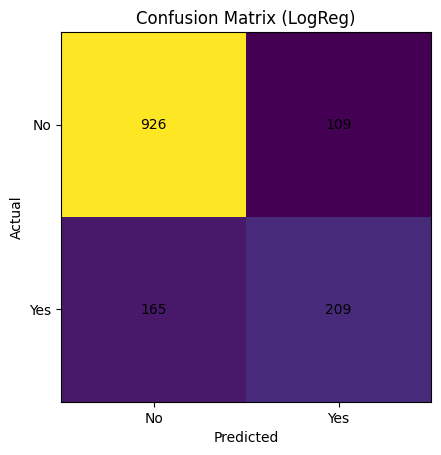

In [11]:
# Single chart (no subplots), default colors
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (LogReg)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0,1], ["No", "Yes"])
plt.yticks([0,1], ["No", "Yes"])

for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, str(z), ha='center', va='center')
plt.show()

In [12]:
# Decision Tree for interpretability
from sklearn.tree import DecisionTreeClassifier

pipe_dt = Pipeline([
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42))
])
pipe_dt.fit(X_train, y_train)
y_pred_dt = pipe_dt.predict(X_test)

print("Decision Tree - Accuracy :", accuracy_score(y_test, y_pred_dt))
print("Decision Tree - Precision:", precision_score(y_test, y_pred_dt, zero_division=0))
print("Decision Tree - Recall   :", recall_score(y_test, y_pred_dt, zero_division=0))
print("Decision Tree - F1-score :", f1_score(y_test, y_pred_dt, zero_division=0))


Decision Tree - Accuracy : 0.71611071682044
Decision Tree - Precision: 0.46632124352331605
Decision Tree - Recall   : 0.48128342245989303
Decision Tree - F1-score : 0.47368421052631576


In [14]:
# ROC Curve / AUC
from sklearn.metrics import roc_curve, auc

plt.figure()
plotted = False

<Figure size 640x480 with 0 Axes>

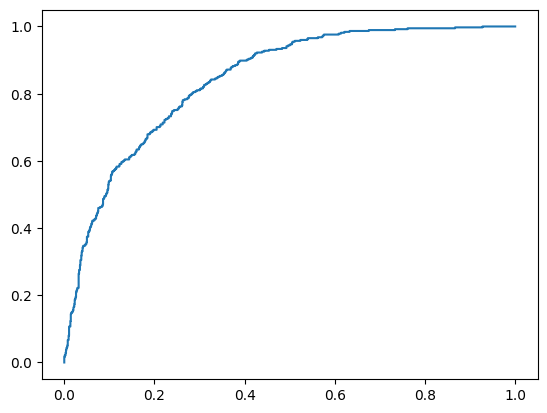

In [15]:
# Logistic Regression
if hasattr(pipe_lr, "predict_proba"):
    proba_lr = pipe_lr.predict_proba(X_test)[:, 1]
    fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_lr)
    auc_lr = auc(fpr_lr, tpr_lr)
    plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={auc_lr:.3f})")
    plotted = True

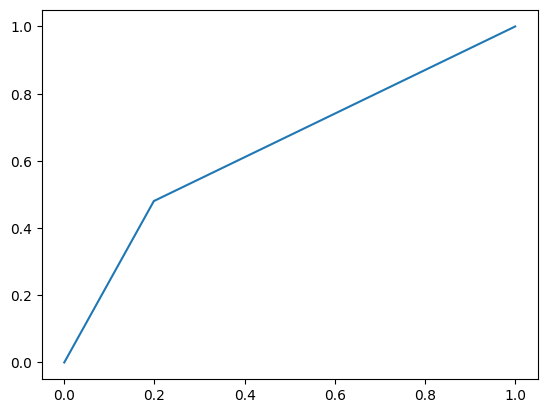

In [16]:
# Decision Tree
if hasattr(pipe_dt, "predict_proba"):
    proba_dt = pipe_dt.predict_proba(X_test)[:, 1]
    fpr_dt, tpr_dt, _ = roc_curve(y_test, proba_dt)
    auc_dt = auc(fpr_dt, tpr_dt)
    plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC={auc_dt:.3f})")
    plotted = True

/tmp/ipython-input-1174448775.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


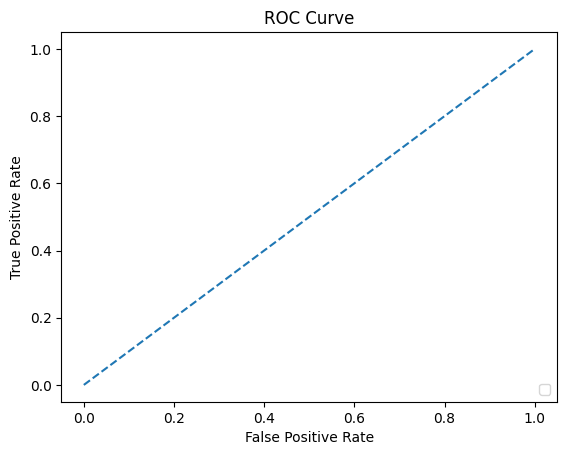

In [17]:
if plotted:
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
plt.show()

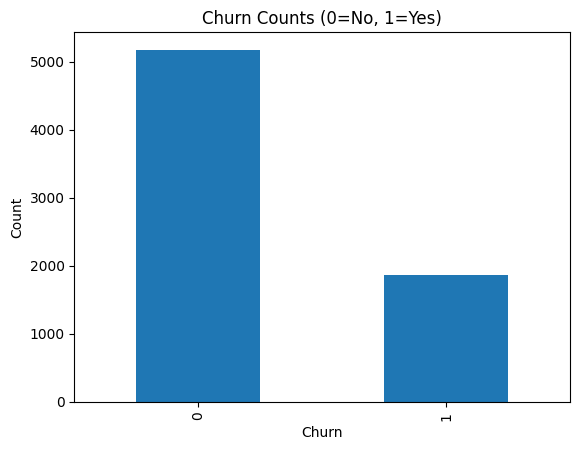

In [19]:
# Simple visualization: churn vs non-churn counts
plt.figure()
df["Churn"].value_counts().sort_index().plot(kind="bar")
plt.title("Churn Counts (0=No, 1=Yes)")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()


<Figure size 640x480 with 0 Axes>

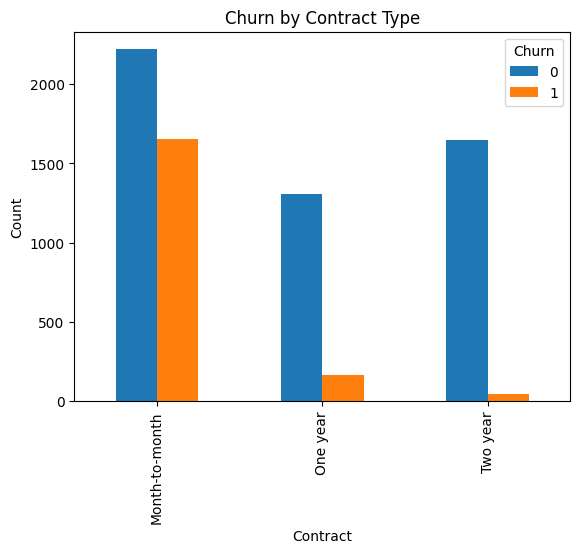

In [20]:
# Distribution of churn across a feature (Contract)
if "Contract" in df.columns:
    plt.figure()
    tmp = df[["Contract", "Churn"]].dropna()
    counts = tmp.groupby(["Contract", "Churn"]).size().unstack(fill_value=0)
    counts.plot(kind="bar")
    plt.title("Churn by Contract Type")
    plt.xlabel("Contract")
    plt.ylabel("Count")
    plt.show()
else:
    print("Column 'Contract' not found; skipping grouped chart.")


In [22]:
# Save trained models and metrics
from joblib import dump
from sklearn.metrics import classification_report
import json

ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(exist_ok=True, parents=True)

In [23]:
# Save both models
dump(pipe_lr, ARTIFACTS_DIR / "model_logistic_regression.joblib")
dump(pipe_dt, ARTIFACTS_DIR / "model_decision_tree.joblib")

['artifacts/model_decision_tree.joblib']

In [24]:
# Pick best by AUC (fallback to F1 if needed)
def score_model(pipe, X, y):
    preds = pipe.predict(X)
    proba = pipe.predict_proba(X)[:, 1] if hasattr(pipe, "predict_proba") else None
    f1 = f1_score(y, preds, zero_division=0)
    model_auc = None
    if proba is not None:
        fpr, tpr, _ = roc_curve(y, proba)
        model_auc = auc(fpr, tpr)
    return f1, model_auc

f1_lr, auc_lr = score_model(pipe_lr, X_test, y_test)
f1_dt, auc_dt = score_model(pipe_dt, X_test, y_test)

In [25]:
# Decide best
score_lr = (-1 if auc_lr is None else auc_lr, f1_lr)
score_dt = (-1 if auc_dt is None else auc_dt, f1_dt)
best_name = "logistic_regression" if score_lr >= score_dt else "decision_tree"
best_pipe = pipe_lr if best_name == "logistic_regression" else pipe_dt
dump(best_pipe, ARTIFACTS_DIR / "best_model.joblib")

['artifacts/best_model.joblib']

In [26]:
# Save confusion matrix figure
plt.figure()
cm_best = confusion_matrix(y_test, best_pipe.predict(X_test))
plt.imshow(cm_best, interpolation="nearest")
plt.title("Confusion Matrix (Best Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0,1], ["No", "Yes"])
plt.yticks([0,1], ["No", "Yes"])
for (i, j), z in np.ndenumerate(cm_best):
    plt.text(j, i, str(z), ha='center', va='center')
plt.savefig(ARTIFACTS_DIR / "confusion_matrix.png", bbox_inches="tight")
plt.close()

In [27]:
# Save ROC curve figure (if any probability-based model)
plt.figure()
plotted = False
if hasattr(pipe_lr, "predict_proba"):
    plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={auc_lr:.3f})")
    plotted = True
if hasattr(pipe_dt, "predict_proba"):
    plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC={auc_dt:.3f})")
    plotted = True
if plotted:
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.savefig(ARTIFACTS_DIR / "roc_curve.png", bbox_inches="tight")
    plt.close()

In [28]:
# Metrics JSON
metrics = {
    "logistic_regression": {
        "accuracy": float(accuracy_score(y_test, y_pred_lr)),
        "precision": float(precision_score(y_test, y_pred_lr, zero_division=0)),
        "recall": float(recall_score(y_test, y_pred_lr, zero_division=0)),
        "f1": float(f1_score(y_test, y_pred_lr, zero_division=0)),
        "auc": (None if auc_lr is None else float(auc_lr)),
        "report": classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0),
    },
    "decision_tree": {
        "accuracy": float(accuracy_score(y_test, y_pred_dt)),
        "precision": float(precision_score(y_test, y_pred_dt, zero_division=0)),
        "recall": float(recall_score(y_test, y_pred_dt, zero_division=0)),
        "f1": float(f1_score(y_test, y_pred_dt, zero_division=0)),
        "auc": (None if auc_dt is None else float(auc_dt)),
        "report": classification_report(y_test, y_pred_dt, output_dict=True, zero_division=0),
    },
    "best_model": best_name
}
with open(ARTIFACTS_DIR / "metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print(f"Saved: {ARTIFACTS_DIR/'best_model.joblib'}, metrics.json, and plots.")


Saved: artifacts/best_model.joblib, metrics.json, and plots.


## Simple one-off prediction demo

In [29]:
# [19] Predict on a single, manual input using the best saved pipeline
from joblib import load

best_model_path = ARTIFACTS_DIR / "best_model.joblib"
pipe = load(best_model_path)

sample = {
    "gender": "Female",
    "SeniorCitizen": 0,
    "Partner": "No",
    "Dependents": "No",
    "tenure": 5,
    "PhoneService": "Yes",
    "MultipleLines": "No",
    "InternetService": "Fiber optic",
    "OnlineSecurity": "No",
    "OnlineBackup": "No",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "Yes",
    "StreamingMovies": "Yes",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 89.1,
    "TotalCharges": 445.5,
}

row = pd.DataFrame([sample])
proba = pipe.predict_proba(row)[:, 1][0]
label = "Will Churn" if proba >= 0.5 else "Will Not Churn"
print(f"Predicted probability of churn: {proba:.3f} -> {label}")


Predicted probability of churn: 0.768 -> Will Churn
